In [1]:
import pandas as pd
from collections import defaultdict

# Load the DataFrame
df = pd.read_csv('new_amplitude_export_2025_chunk_1833655_1851810.csv')

# Drop rows with NaN values in the 'region' column
df = df.dropna(subset=['region'])

# Print unique regions
print(set(df['region']))

# Convert timestamps to datetime format
df['event_time'] = pd.to_datetime(df['event_time'])
df['client_upload_time'] = pd.to_datetime(df['client_upload_time'])

# Sort by session_id and event_time before grouping
df = df.sort_values(by=['session_id', 'event_time'])

# Group rows by 'session_id' and extract the sequence of event_type (paths)
paths = defaultdict(list)
for session_id, group in df.groupby('session_id'):
    paths[session_id] = group['event_type'].tolist()  # Extract the sequence of event_type

# Print the paths
for session_id, path in paths.items():
    print(f"Session ID: {session_id}, Path: {path}")

{'Illinois', 'Massachusetts', 'Alajuela Province', 'Washington', 'Texas', 'Maryland', 'Alabama', 'Ontario', 'Lower Silesia', 'Ohio', 'Connecticut', 'Georgia', 'British Columbia', 'Michigan', 'Maharashtra', 'Mazovia', 'Kujawsko-Pomorskie', 'California', 'Missouri', 'Virginia', 'Iowa', 'Oregon', 'Wyoming', 'South Carolina', 'New York', 'Colorado', 'New Jersey', 'Arizona', 'North Carolina', 'Tennessee', 'District of Columbia', 'Kansas', 'Utah', 'Florida'}
Session ID: 1713877756240, Path: ['session_end', 'session_end']
Session ID: 1719496016361, Path: ['session_end', 'session_end']
Session ID: 1723482967949, Path: ['session_end']
Session ID: 1727804976348, Path: ['session_end', 'session_end']
Session ID: 1731958982350, Path: ['session_end']
Session ID: 1734546713731, Path: ['session_end']
Session ID: 1735310140202, Path: ['session_end']
Session ID: 1735847372981, Path: ['session_end']
Session ID: 1735886749310, Path: ['session_end']
Session ID: 1735909111236, Path: ['session_end']
Session 

In [2]:
from collections import defaultdict

df = pd.read_csv('new_amplitude_export_2025_chunk_1833655_1851810.csv')
df['event_time'] = pd.to_datetime(df['event_time'])
df = df.sort_values(by=['session_id', 'event_time'])

# Group events by session to track user paths
paths = defaultdict(list)
for session_id, group in df.groupby('session_id'):
    paths[session_id] = group['event_type'].tolist()

# Count feature transitions (e.g., A -> B)
transition_counts = defaultdict(lambda: defaultdict(int))
for path in paths.values():
    for i in range(len(path) - 1):
        transition_counts[path[i]][path[i + 1]] += 1  

# Convert counts to transition probabilities (percentages)
transition_matrix = []
for state, transitions in transition_counts.items():
    total = sum(transitions.values())  
    for next_state, count in transitions.items():
        probability = round((count / total) * 100, 2)
        transition_matrix.append((f"{state} -> {next_state}", probability))

# Convert to DataFrame 
transition_df = pd.DataFrame(transition_matrix, columns=["Transition", "Probability"])
transition_df = transition_df.sort_values(by="Transition").reset_index(drop=True)

pd.set_option('display.float_format', '{:.2f}%'.format)
print("Transition Matrix (Percentages):\n")
print(transition_df.to_string(index=False, col_space=0, justify='left'))

Transition Matrix (Percentages):

Transition                                                                                                                                           Probability
                                                                                         ::configurable-table:render -> ::configurable-table:render  61.22%     
                                                                                    ::configurable-table:render -> ::nav-header:action-center-click   2.04%     
                                                                                                     ::configurable-table:render -> ::widget:render   4.08%     
                                                                             ::configurable-table:render -> :all-accounts:configurable-table:render   2.04%     
                                                                                         ::configurable-table:render -> :all-accounts:layout:render   2.04%     


In [3]:
# Load the DataFrame
df = pd.read_csv('new_amplitude_export_2025_chunk_1833655_1851810.csv')

# Get unique features
unique_features = df['event_type'].unique()

# Print the list
print("Unique Features in the Dataset:")
print(unique_features)

Unique Features in the Dataset:
['application-window-opened' 'dashboard:my-book::view'
 'dashboard:my-book:layout:render' 'dashboard:my-book:widget:render'
 'dashboard:my-book:configurable-table:render' 'session_start'
 'session_end' ':all-accounts:layout:render' ':all-accounts::view'
 ':all-accounts:configurable-table:render' ':all-accounts:widget:render'
 'account-lines::layout:render' 'account-lines:::view' 'account:::view'
 'account-lines::widget:render' 'account-lines::configurable-table:render'
 '::nav-header:action-center-click' 'action-center:::view'
 'action-center:::close-click' 'action-center:action-details::view'
 'all-accounts:new-business:layout:render'
 'all-accounts:new-business::view'
 'all-accounts:new-business:accounts-table:account-click'
 'submissions:all-policy:configurable-table:render'
 'submissions:all-policy::view'
 'triaged-submission-list:my-book:configurable-table:render'
 'triaged-submission-list:my-book::view' 'submissions:all-exposures::view'
 'submissio

In [4]:
def predict_next_feature(current_feature, transition_matrix):
    if current_feature in transition_matrix:
        return max(transition_matrix[current_feature], key=transition_matrix[current_feature].get, default=None)
    return None  

current_state = "::configurable-table:render"
predicted_next = predict_next_feature(current_state, transition_counts)
print(predicted_next)

::configurable-table:render


In [8]:
import pandas as pd
import numpy as np
import os
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Load CSVs and process in chunks
data_folder = 'data'
paths = defaultdict(list)
event_types = set()

for file in os.listdir(data_folder):
    if file.endswith('.csv'):
        df = pd.read_csv(os.path.join(data_folder, file), usecols=['session_id', 'event_time', 'event_type'])
        df['event_time'] = pd.to_datetime(df['event_time'])
        df = df.sort_values(by=['session_id', 'event_time'])
        
        for session_id, group in df.groupby('session_id'):
            event_list = group['event_type'].tolist()
            paths[session_id].extend(event_list)
            event_types.update(event_list)

# Encode event types
label_encoder = LabelEncoder()
label_encoder.fit(list(event_types))

def encode_sequence(seq):
    encoded = [label_encoder.transform([event])[0] for event in seq if event in label_encoder.classes_]
    return [0] * (5 - len(encoded)) + encoded  # Pad to length 5

# Create training data
X, y = [], []
for path in paths.values():
    for i in range(len(path) - 1):
        X.append(encode_sequence(path[max(0, i-4):i+1]))  # Use up to 4 past events
        y.append(path[i+1])  # Predict next event

X = np.array(X)
y = label_encoder.transform(y)

# Remove rare classes (less than 2 occurrences)
counts = Counter(y)
valid_classes = {cls for cls, count in counts.items() if count >= 2}
valid_indices = [i for i in range(len(y)) if y[i] in valid_classes]
X, y = X[valid_indices], y[valid_indices]

# Re-map labels to continuous range
unique_classes = sorted(set(y))
class_mapping = {old: new for new, old in enumerate(unique_classes)}
y = np.array([class_mapping[label] for label in y])

# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train an XGBoost Classifier
clf = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=42, tree_method='hist')
clf.fit(X_train, y_train)

# Evaluate accuracy
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

Model Accuracy: 71.24%


In [18]:
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Load a single CSV
df = pd.read_csv('new_amplitude_export_2025_chunk_1833655_1851810.csv')
df['event_time'] = pd.to_datetime(df['event_time'])
df = df.sort_values(by=['session_id', 'event_time'])

# Group events by session
paths = defaultdict(list)
session_lengths = {}
for session_id, group in df.groupby('session_id'):
    paths[session_id] = group['event_type'].tolist()
    session_lengths[session_id] = len(group)

# Create training data
X, y = [], []
for session_id, path in paths.items():
    session_length = session_lengths[session_id]
    for i in range(len(path) - 1):
        X.append((path[max(0, i-12):i+1], session_length))  # Use up to the past 12 events
        y.append(path[i+1])  # Predict next event

# Convert sequences to feature vectors
label_encoder = LabelEncoder()
all_events = df['event_type'].unique()
label_encoder.fit(all_events)

def encode_sequence(seq, session_length):
    encoded = [label_encoder.transform([event])[0] if event in label_encoder.classes_ else -1 for event in seq]
    padded_sequence = [0] * (13 - len(encoded)) + encoded  # Pad to length 13
    return padded_sequence + [session_length]  # Append session length as a feature

X = np.array([encode_sequence(seq, length) for seq, length in X])
y = label_encoder.transform(y)

# Remove rare classes (less than 2 occurrences)
counts = Counter(y)
rare_classes = {cls for cls, count in counts.items() if count < 2}
valid_indices = [i for i in range(len(y)) if y[i] not in rare_classes]
X, y = X[valid_indices], y[valid_indices]

# Re-map labels to continuous range
unique_classes = sorted(set(y))
class_mapping = {old: new for new, old in enumerate(unique_classes)}
y = np.array([class_mapping[label] for label in y])

# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train an XGBoost Classifier
clf = XGBClassifier(n_estimators=400, learning_rate=0.03, max_depth=9, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

Model Accuracy: 77.54%


In [19]:
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Load a single CSV
df = pd.read_csv('new_amplitude_export_2025_chunk_1833655_1851810.csv')
df['event_time'] = pd.to_datetime(df['event_time'])
df = df.sort_values(by=['session_id', 'event_time'])

# Group events by session
paths = defaultdict(list)
session_lengths = {}
for session_id, group in df.groupby('session_id'):
    paths[session_id] = group['event_type'].tolist()
    session_lengths[session_id] = len(group)

# Create training data
X, y = [], []
for session_id, path in paths.items():
    session_length = session_lengths[session_id]
    for i in range(len(path) - 1):
        X.append((path[max(0, i-12):i+1], session_length))  # Use up to the past 12 events
        y.append(path[i+1])  # Predict next event

# Convert sequences to feature vectors
label_encoder = LabelEncoder()
all_events = df['event_type'].unique()
label_encoder.fit(all_events)

def encode_sequence(seq, session_length):
    encoded = [label_encoder.transform([event])[0] if event in label_encoder.classes_ else -1 for event in seq]
    padded_sequence = [0] * (13 - len(encoded)) + encoded  # Pad to length 13
    return padded_sequence + [session_length]  # Append session length as a feature

X = np.array([encode_sequence(seq, length) for seq, length in X])
y = label_encoder.transform(y)

# Remove rare classes (less than 2 occurrences)
counts = Counter(y)
rare_classes = {cls for cls, count in counts.items() if count < 2}
valid_indices = [i for i in range(len(y)) if y[i] not in rare_classes]
X, y = X[valid_indices], y[valid_indices]

# Re-map labels to continuous range
unique_classes = sorted(set(y))
class_mapping = {old: new for new, old in enumerate(unique_classes)}
y = np.array([class_mapping[label] for label in y])

# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train an XGBoost Classifier
clf = XGBClassifier(n_estimators=500, learning_rate=0.02, max_depth=10, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

Model Accuracy: 77.73%


In [6]:
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Load a single CSV
df = pd.read_csv('new_amplitude_export_2025_chunk_1833655_1851810.csv')
df['event_time'] = pd.to_datetime(df['event_time'])
df = df.sort_values(by=['session_id', 'event_time'])

# Group events by session
paths = defaultdict(list)
session_lengths = {}
for session_id, group in df.groupby('session_id'):
    event_list = group['event_type'].tolist()
    
    # Remove sessions with only one event or exactly ['session_start', 'session_end']
    if len(event_list) > 1 and event_list != ['session_start', 'session_end']:
        filtered_events = []
        for i in range(len(event_list) - 1):
            if not ((event_list[i] == 'session_start' and event_list[i+1] == 'session_start') or
                    (event_list[i] == 'session_start' and event_list[i+1] == 'session_end') or
                    (event_list[i] == 'session_end' and event_list[i+1] == 'session_end')):
                filtered_events.append(event_list[i])
        
        if filtered_events:
            paths[session_id] = filtered_events + [event_list[-1]]  # Ensure last event is added
            session_lengths[session_id] = len(filtered_events)

# Create training data
X, y = [], []
for session_id, path in paths.items():
    session_length = session_lengths[session_id]
    for i in range(len(path) - 1):
        X.append((path[max(0, i-12):i+1], session_length))  # Use up to the past 12 events
        y.append(path[i+1])  # Predict next event

# Convert sequences to feature vectors
label_encoder = LabelEncoder()
all_events = df['event_type'].unique()
label_encoder.fit(all_events)

def encode_sequence(seq, session_length):
    encoded = [label_encoder.transform([event])[0] if event in label_encoder.classes_ else -1 for event in seq]
    padded_sequence = [0] * (13 - len(encoded)) + encoded  # Pad to length 13
    return padded_sequence + [session_length]  # Append session length as a feature

X = np.array([encode_sequence(seq, length) for seq, length in X])
y = label_encoder.transform(y)

# Remove rare classes (less than 2 occurrences)
counts = Counter(y)
rare_classes = {cls for cls, count in counts.items() if count < 2}
valid_indices = [i for i in range(len(y)) if y[i] not in rare_classes]
X, y = X[valid_indices], y[valid_indices]

# Re-map labels to continuous range
unique_classes = sorted(set(y))
class_mapping = {old: new for new, old in enumerate(unique_classes)}
y = np.array([class_mapping[label] for label in y])

# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train an XGBoost Classifier
clf = XGBClassifier(n_estimators=650, learning_rate=0.015, max_depth=12, random_state=42, subsample=0.8, colsample_bytree=0.8)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

Model Accuracy: 77.72%


In [4]:
# Count sessions that are exactly ['session_start', 'session_end']
count_session_start_end = df.groupby('session_id')['event_type'].apply(lambda x: list(x)).tolist().count(['session_start', 'session_end'])

print(f"Number of session_start to session_end sessions: {count_session_start_end}")

# Count sessions that are exactly ['session_start', 'session_end']
count_session_start_end = sum(1 for events in paths.values() if events == ['session_start', 'session_end'])

print(f"Number of session_start to session_end sessions: {count_session_start_end}")

Number of session_start to session_end sessions: 224
Number of session_start to session_end sessions: 0


In [5]:
print(f"Total unique session IDs: {df['session_id'].nunique()}")

Total unique session IDs: 837


In [ ]:
print("test")

In [8]:
import pandas as pd
import json
import xgboost as xgb
import numpy as np
import os
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load event encoding from message.json
with open("message.json", "r") as file:
    EVENT_ENCODING = json.load(file)

# Reverse mapping from numbers back to event names
EVENT_DECODING = {v: k for k, v in EVENT_ENCODING.items()}

# Define function to categorize time of day
def categorize_time_of_day(timestamp):
    hour = pd.to_datetime(timestamp).hour
    if 0 <= hour < 6:
        return "early_morning"
    elif 6 <= hour < 11:
        return "morning"
    elif 11 <= hour < 16:
        return "afternoon"
    elif 16 <= hour < 19:
        return "evening"
    else:
        return "night"

# Get all CSV file paths from the 'data' folder
folder_path = "data"
file_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".csv")]

# Load datasets
dataframes = []
for file in file_paths:
    print(f"Loading: {file} ...")
    df = pd.read_csv(file)
    dataframes.append(df)

# Combine all data
df = pd.concat(dataframes, ignore_index=True)
print(f"Total dataset size: {df.shape[0]} rows, {df.shape[1]} columns.")

# Drop sessions that only contain session_start and session_end
df = df[df.duplicated(subset=['session_id'], keep=False)]
print(f"Remaining rows after filtering sessions: {df.shape[0]}")

# Convert timestamps
df["event_time"] = pd.to_datetime(df["event_time"])

# Create new features
df["time_of_day"] = df["event_time"].apply(categorize_time_of_day)

# Drop NaN values in critical columns
df = df.dropna(subset=['region', 'event_type', 'time_of_day'])

# Encode categorical features
region_encoder = LabelEncoder()
df["region_encoded"] = region_encoder.fit_transform(df["region"])
df["time_of_day_encoded"] = LabelEncoder().fit_transform(df["time_of_day"])

# Encode event types
df["event_encoded"] = df["event_type"].map(EVENT_ENCODING)

# Drop NaN values after encoding
df = df.dropna(subset=["event_encoded"])
df["event_encoded"] = df["event_encoded"].astype(int)

# Aggregate paths per session
session_paths = df.groupby(["session_id"]).agg(
    {"event_encoded": list, "region_encoded": "first", "time_of_day_encoded": "first"}
).reset_index()

# Keep session paths where session start/end are not over 50%
session_paths = session_paths[session_paths["event_encoded"].apply(
    lambda x: (x.count(171) + x.count(170)) / len(x) < 0.5
)]
print(f"Remaining unique event sequences after filtering: {session_paths.shape[0]}")

# Convert user paths to string format for classification
session_paths["event_sequence"] = session_paths["event_encoded"].apply(lambda x: " ".join(map(str, x)))

# Filter event sequences that occur at least twice
sequence_counts = session_paths["event_sequence"].value_counts()
valid_sequences = sequence_counts[sequence_counts > 1].index
session_paths = session_paths[session_paths["event_sequence"].isin(valid_sequences)]
print(f"Remaining event sequences after removing rare ones: {session_paths.shape[0]}")

# Train-test split
X = session_paths[["region_encoded", "time_of_day_encoded"]]
y = session_paths["event_sequence"]

# Encode event sequences into integer labels
sequence_encoder = LabelEncoder()
y_encoded = sequence_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

print(f"Final training set size: {len(y_train)}")
print(f"Final test set size: {len(y_test)}")

# Train XGBoost model
model = xgb.XGBClassifier(objective="multi:softprob", num_class=len(sequence_encoder.classes_), eval_metric="mlogloss")
model.fit(X_train, y_train)

# Get Probabilities Instead of Single Predictions
y_prob = model.predict_proba(X_test)

# Get Top N Predictions
N = 3  # Number of top event paths to return
top_n_preds = np.argsort(y_prob, axis=1)[:, -N:]

# Convert back to original event sequences (readable strings)
top_n_paths = [[sequence_encoder.inverse_transform([idx]) for idx in row] for row in top_n_preds]

# Display results
print("\n📌 Sample Top-N Predictions:")
for i in range(10):
    region = region_encoder.inverse_transform([X_test.iloc[i, 0]])[0]
    time_of_day = X_test.iloc[i, 1]
    actual_path = " -> ".join([EVENT_DECODING[int(event)] for event in sequence_encoder.inverse_transform([y_test[i]])[0].split()])
    predicted_paths = [" -> ".join([EVENT_DECODING[int(event)] for event in sequence[0].split()]) for sequence in top_n_paths[i]]

    print(f"Region: {region}, Time of Day: {time_of_day}")
    print(f"Actual Path: {actual_path}")
    print(f"Top {N} Predicted Paths: {predicted_paths}\n")

Loading: data\new_amplitude_export_2025_chunk_0_18155.csv ...
Loading: data\new_amplitude_export_2025_chunk_1016680_1034835.csv ...
Loading: data\new_amplitude_export_2025_chunk_1034835_1052990.csv ...
Loading: data\new_amplitude_export_2025_chunk_1052990_1071145.csv ...
Loading: data\new_amplitude_export_2025_chunk_1071145_1089300.csv ...
Loading: data\new_amplitude_export_2025_chunk_1089300_1107455.csv ...
Loading: data\new_amplitude_export_2025_chunk_108930_127085.csv ...
Loading: data\new_amplitude_export_2025_chunk_1107455_1125610.csv ...
Loading: data\new_amplitude_export_2025_chunk_1125610_1143765.csv ...
Loading: data\new_amplitude_export_2025_chunk_1143765_1161920.csv ...
Loading: data\new_amplitude_export_2025_chunk_1161920_1180075.csv ...
Loading: data\new_amplitude_export_2025_chunk_1180075_1198230.csv ...
Loading: data\new_amplitude_export_2025_chunk_1198230_1216385.csv ...
Loading: data\new_amplitude_export_2025_chunk_1216385_1234540.csv ...
Loading: data\new_amplitude_ex

In [15]:
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import joblib  # To save the trained model

# Load CSV
df = pd.read_csv('new_amplitude_export_2025_chunk_1833655_1851810.csv')
df['event_time'] = pd.to_datetime(df['event_time'])
df = df.sort_values(by=['session_id', 'event_time'])

# Group events by session
paths = defaultdict(list)
session_lengths = {}
for session_id, group in df.groupby('session_id'):
    paths[session_id] = group['event_type'].tolist()
    session_lengths[session_id] = len(group)

# Prepare training data
X, y = [], []
for session_id, path in paths.items():
    session_length = session_lengths[session_id]
    for i in range(len(path) - 1):
        X.append((path[max(0, i-12):i+1], session_length))  # Use past 12 events
        y.append(path[i+1])  # Predict next event

# Encode sequences
label_encoder = LabelEncoder()
all_events = df['event_type'].unique()
label_encoder.fit(all_events)

def encode_sequence(seq, session_length):
    encoded = [label_encoder.transform([event])[0] if event in label_encoder.classes_ else -1 for event in seq]
    padded_sequence = [0] * (13 - len(encoded)) + encoded  # Pad to length 13
    return padded_sequence + [session_length]  # Append session length as a feature

X = np.array([encode_sequence(seq, length) for seq, length in X])
y = label_encoder.transform(y)

# Remove rare classes
counts = Counter(y)
rare_classes = {cls for cls, count in counts.items() if count < 2}
valid_indices = [i for i in range(len(y)) if y[i] not in rare_classes]
X, y = X[valid_indices], y[valid_indices]

# Re-map labels
unique_classes = sorted(set(y))
class_mapping = {old: new for new, old in enumerate(unique_classes)}
y = np.array([class_mapping[label] for label in y])

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train XGBoost Model
clf = XGBClassifier(n_estimators=650, learning_rate=0.015, max_depth=12, random_state=42, subsample=0.8, colsample_bytree=0.8)
clf.fit(X_train, y_train)

# Evaluate Model
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# Save Model and Label Encoder
joblib.dump(clf, "next_feature_model.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")

Model Accuracy: 77.89%


['label_encoder.pkl']

In [19]:
import numpy as np
import joblib

# Load Trained Model and Label Encoder
clf = joblib.load("next_feature_model.pkl")
label_encoder = joblib.load("label_encoder.pkl")

def predict_next_feature(previous_path, session_length):
    """ Predicts the next feature based on previous user path """
    # Encode the sequence
    encoded = [label_encoder.transform([event])[0] if event in label_encoder.classes_ else -1 for event in previous_path]
    padded_sequence = [0] * (13 - len(encoded)) + encoded  # Pad to length 13
    input_vector = np.array([padded_sequence + [session_length]])  # Append session length

    # Predict
    predicted_label = clf.predict(input_vector)[0]
    predicted_event = label_encoder.inverse_transform([predicted_label])[0]
    
    return predicted_event

# Example usage
example_path = ['session_start', 'account-lines::widget:render', 'account-lines::widget:render']  # Example past events
predicted_feature = predict_next_feature(example_path, session_length)
print(f"Predicted Next Feature: {predicted_feature}")

Predicted Next Feature: account-lines:::change-rating-click


In [21]:
import pickle

# Save the model
with open("next_feature_model.pkl", "wb") as file:
    pickle.dump(clf, file)

# Save the label encoder
with open("label_encoder.pkl", "wb") as file:
    pickle.dump(label_encoder, file)

print("Model and label encoder saved using pickle.")

Model and label encoder saved using pickle.


In [26]:
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import joblib  # For saving and loading the model

# Load CSV
df = pd.read_csv('new_amplitude_export_2025_chunk_1833655_1851810.csv')
df['event_time'] = pd.to_datetime(df['event_time'])
df = df.sort_values(by=['session_id', 'event_time'])

# Group events by session
paths = defaultdict(list)
session_lengths = {}
for session_id, group in df.groupby('session_id'):
    paths[session_id] = group['event_type'].tolist()
    session_lengths[session_id] = len(group)

# Prepare training data
X, y = [], []
for session_id, path in paths.items():
    session_length = session_lengths[session_id]
    for i in range(len(path) - 1):
        X.append((path[max(0, i-12):i+1], session_length))  # Use up to the past 12 events
        y.append(path[i+1])  # Predict next event

# Encode event names as integers
label_encoder = LabelEncoder()
all_events = df['event_type'].unique()
label_encoder.fit(all_events)

def encode_sequence(seq, session_length):
    encoded = [label_encoder.transform([event])[0] if event in label_encoder.classes_ else -1 for event in seq]
    padded_sequence = [0] * (13 - len(encoded)) + encoded  # Pad to length 13
    return padded_sequence + [session_length]  # Append session length as a feature

X = np.array([encode_sequence(seq, length) for seq, length in X])
y = label_encoder.transform(y)

# Remove rare classes
counts = Counter(y)
rare_classes = {cls for cls, count in counts.items() if count < 2}
valid_indices = [i for i in range(len(y)) if y[i] not in rare_classes]
X, y = X[valid_indices], y[valid_indices]

# Re-map labels to continuous range
unique_classes = sorted(set(y))
class_mapping = {old: new for new, old in enumerate(unique_classes)}
y = np.array([class_mapping[label] for label in y])

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train XGBoost Model
clf = XGBClassifier(n_estimators=650, learning_rate=0.015, max_depth=12, random_state=42, subsample=0.8, colsample_bytree=0.8)
clf.fit(X_train, y_train)

# Evaluate Model
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# Save Model and Label Encoder
joblib.dump(clf, "next_feature_model.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")

Model Accuracy: 77.89%


['label_encoder.pkl']

In [29]:
import numpy as np
import joblib

# Load Model and Label Encoder
clf = joblib.load("next_feature_model.pkl")  # Load trained model
label_encoder = joblib.load("label_encoder.pkl")  # Load label encoder

def predict_next_feature(previous_path, session_length=DEFAULT_SESSION_LENGTH):
    """ Predicts the next feature based on the past user path. """
    # Encode the sequence
    encoded = [label_encoder.transform([event])[0] if event in label_encoder.classes_ else -1 for event in previous_path]
    padded_sequence = [0] * (13 - len(encoded)) + encoded  # Pad to length 13
    input_vector = np.array([padded_sequence + [session_length]])  # Append session length

    # Predict next event
    predicted_label = clf.predict(input_vector)[0]
    predicted_event = label_encoder.inverse_transform([predicted_label])[0]
    
    return predicted_event

# Example Test
example_path = ['session_start', 'account-lines::widget:render', 'account-lines::widget:render']
predicted_feature = predict_next_feature(example_path)
print(f"Predicted Next Feature: {predicted_feature}")

Predicted Next Feature: account-lines:::change-rating-click


In [32]:
import pandas as pd

# Load the dataset
df = pd.read_csv('new_amplitude_export_2025_chunk_1833655_1851810.csv')

# Convert timestamps
df['event_time'] = pd.to_datetime(df['event_time'])
df['client_event_time'] = pd.to_datetime(df['client_event_time'])

# 1. Top 10 Active Countries
country_sessions = df.groupby('country')['session_id'].nunique().sort_values(ascending=False).head(10)
print("Top 10 Active Countries (by sessions):\n", country_sessions)

# 2. Average Session Duration by Country
df['session_start_time'] = df.groupby('session_id')['event_time'].transform('min')
df['session_end_time'] = df.groupby('session_id')['event_time'].transform('max')
df['session_duration'] = (df['session_end_time'] - df['session_start_time']).dt.total_seconds()

avg_session_duration = df.groupby('country')['session_duration'].mean().sort_values(ascending=False)
print("\nAverage Session Duration by Country (seconds):\n", avg_session_duration.head(10))

# 3. Peak Usage Hours (Hourly Distribution)
df['hour'] = df['event_time'].dt.hour
hourly_usage = df.groupby('hour')['session_id'].nunique().sort_values(ascending=False)
print("\nPeak Usage Hours:\n", hourly_usage)

# 4. Peak Usage Days
df['weekday'] = df['event_time'].dt.day_name()
daily_usage = df.groupby('weekday')['session_id'].nunique().sort_values(ascending=False)
print("\nUsage by Day of the Week:\n", daily_usage)

# 5. Most Used Features
top_features = df['event_type'].value_counts().head(10)
print("\nTop 10 Most Used Features:\n", top_features)

Top 10 Active Countries (by sessions):
 country
United States    735
India             72
Canada            16
Poland            13
Costa Rica         1
Name: session_id, dtype: int64

Average Session Duration by Country (seconds):
 country
India            2348.737379
Poland           1383.666952
United States    1339.710094
Canada            178.148843
Costa Rica        113.254000
Name: session_duration, dtype: float64

Peak Usage Hours:
 hour
16    233
18    223
10    103
15     56
17     41
1      38
20     27
23     21
8      21
9      18
13     17
14     16
0       5
19      4
21      4
22      4
12      3
3       3
7       2
5       2
6       1
4       1
Name: session_id, dtype: int64

Usage by Day of the Week:
 weekday
Monday       420
Tuesday      272
Sunday        45
Wednesday     44
Saturday      38
Friday        14
Thursday       4
Name: session_id, dtype: int64

Top 10 Most Used Features:
 event_type
account-lines::widget:render                   3877
account-lines::config

In [35]:
import pandas as pd
import os
import glob

# Path to the folder containing CSV files
folder_path = "data"

# Get all CSV file paths
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# Initialize an empty list to store data
all_data = []

# Load and process each CSV
for file in csv_files:
    df = pd.read_csv(file, low_memory=False)
    df['event_time'] = pd.to_datetime(df['event_time'], errors='coerce')  # Convert to datetime
    df['hour'] = df['event_time'].dt.hour  # Extract hour
    all_data.append(df[['hour']])  # Keep only necessary column

# Combine all data
full_df = pd.concat(all_data, ignore_index=True)

# Count occurrences per hour
peak_usage_hours = full_df['hour'].value_counts().sort_values(ascending=False)

# Display results
print("Peak Usage Hours (All CSVs Combined):")
print(peak_usage_hours)

Peak Usage Hours (All CSVs Combined):
hour
15    160241
16    151129
19    137684
14    133045
17    131961
20    131027
18    121523
21    113741
13     91591
22     76740
12     67925
10     65470
11     64175
8      56650
9      55150
6      55000
7      54778
5      52265
23     37152
4      35544
0      17412
3      15187
1      13352
2      11367
Name: count, dtype: int64


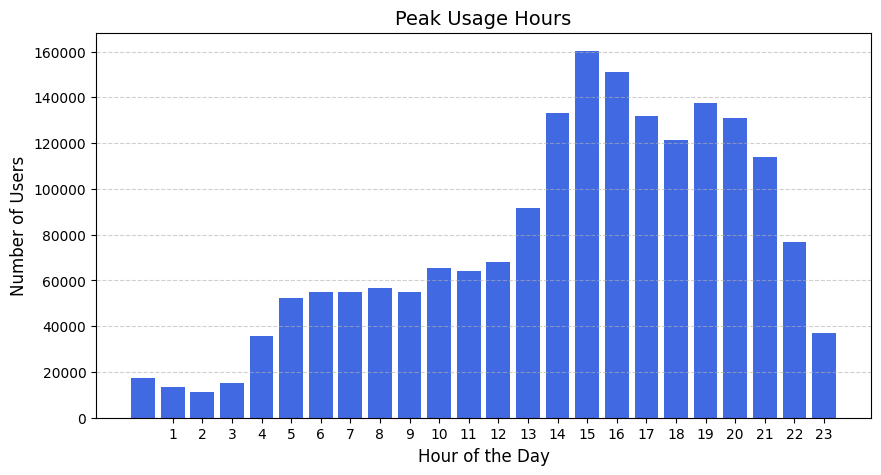

In [37]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt

# Path to the folder containing CSV files
folder_path = "data"

# Get all CSV file paths
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# Initialize an empty list to store data
all_data = []

# Load and process each CSV
for file in csv_files:
    df = pd.read_csv(file, low_memory=False)
    df['event_time'] = pd.to_datetime(df['event_time'], errors='coerce')  # Convert to datetime
    df['hour'] = df['event_time'].dt.hour  # Extract hour
    all_data.append(df[['hour']])  # Keep only necessary column

# Combine all data
full_df = pd.concat(all_data, ignore_index=True)

# Count occurrences per hour
peak_usage_hours = full_df['hour'].value_counts().sort_index()

# Plot the graph
plt.figure(figsize=(10, 5))
plt.bar(peak_usage_hours.index, peak_usage_hours.values, color='royalblue')

# Format the x-axis to remove leading zero
plt.xticks(ticks=range(1, 24), labels=[str(i) for i in range(1, 24)])

# Labels and title
plt.xlabel("Hour of the Day", fontsize=12)
plt.ylabel("Number of Users", fontsize=12)
plt.title("Peak Usage Hours", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Show the plot
plt.show()

In [39]:
import pandas as pd
import os
from glob import glob

# Folder containing all CSVs
data_folder = "data"
csv_files = glob(os.path.join(data_folder, "*.csv"))

# Dictionary to store session durations by country
country_session_data = {}

# Process each CSV file
for file in csv_files:
    df = pd.read_csv(file, low_memory=False)

    # Ensure required columns exist
    if 'event_time' in df.columns and 'country' in df.columns and 'session_id' in df.columns:
        df['event_time'] = pd.to_datetime(df['event_time'])

        # Calculate session duration for each session
        session_durations = df.groupby('session_id')['event_time'].agg(lambda x: (x.max() - x.min()).total_seconds())

        # Merge session durations with country data
        session_countries = df[['session_id', 'country']].drop_duplicates().set_index('session_id')
        session_countries = session_countries.join(session_durations, how='inner')

        # Aggregate session durations by country
        for country, duration in session_countries.groupby('country')['event_time'].mean().items():
            if country in country_session_data:
                country_session_data[country].append(duration)
            else:
                country_session_data[country] = [duration]

# Compute the final average session duration per country
country_avg_durations = {country: sum(durations) / len(durations) for country, durations in country_session_data.items()}

# Find the country with the longest average session duration
max_country = max(country_avg_durations, key=country_avg_durations.get)
max_duration = country_avg_durations[max_country]

print(f"Country with the longest average session duration: {max_country} ({max_duration:.2f} seconds)")

Country with the longest average session duration: India (688.88 seconds)


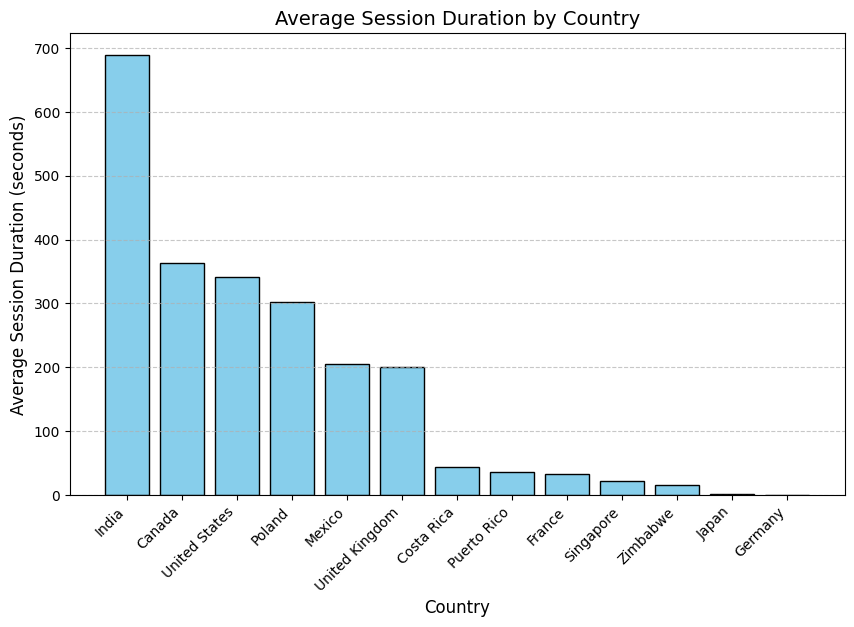

In [40]:
import matplotlib.pyplot as plt

# Sort countries by average session duration (descending)
sorted_countries = sorted(country_avg_durations.items(), key=lambda x: x[1], reverse=True)
countries, durations = zip(*sorted_countries)

# Plot
plt.figure(figsize=(10, 6))
plt.bar(countries, durations, color='skyblue', edgecolor='black')

# Labels and Title
plt.xlabel("Country", fontsize=12)
plt.ylabel("Average Session Duration (seconds)", fontsize=12)
plt.title("Average Session Duration by Country", fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate country names for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show Plot
plt.show()

In [41]:
import pandas as pd
import os

# Folder containing the CSV files
data_folder = "data"

# Set to store unique countries
unique_countries = set()

# Loop through all CSV files
for file in os.listdir(data_folder):
    if file.endswith(".csv"):
        file_path = os.path.join(data_folder, file)
        df = pd.read_csv(file_path, usecols=['country'], low_memory=False)
        
        # Add unique countries from the file to the set
        unique_countries.update(df['country'].dropna().unique())

# Print the number of unique countries
print(f"Total Unique Countries: {len(unique_countries)}")

Total Unique Countries: 13


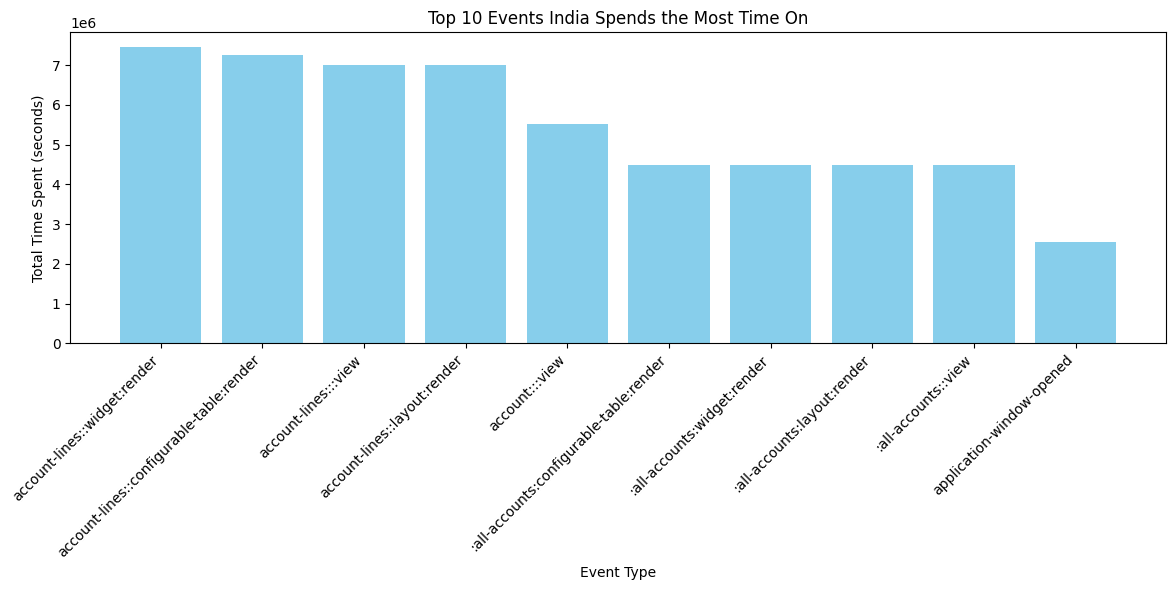

In [42]:
import pandas as pd
import os
import matplotlib.pyplot as plt

# Folder containing the CSV files
data_folder = "data"

# Dictionary to store total time spent per event for India
event_time_spent = {}

# Loop through all CSV files
for file in os.listdir(data_folder):
    if file.endswith(".csv"):
        file_path = os.path.join(data_folder, file)
        df = pd.read_csv(file_path, usecols=['country', 'event_type', 'event_time', 'session_id'], low_memory=False)
        
        # Convert event_time to datetime format
        df['event_time'] = pd.to_datetime(df['event_time'], errors='coerce')
        
        # Filter for India
        df_india = df[df['country'] == 'India']
        
        # Calculate session duration per event
        session_durations = df_india.groupby(['session_id', 'event_type'])['event_time'].agg(['min', 'max'])
        session_durations['duration'] = (session_durations['max'] - session_durations['min']).dt.total_seconds()
        
        # Aggregate total duration per event
        event_totals = session_durations.groupby('event_type')['duration'].sum()

        # Update global dictionary
        for event, duration in event_totals.items():
            if event in event_time_spent:
                event_time_spent[event] += duration
            else:
                event_time_spent[event] = duration

# Convert to DataFrame for plotting
event_time_df = pd.DataFrame(event_time_spent.items(), columns=['event_type', 'total_time'])
event_time_df = event_time_df.sort_values(by='total_time', ascending=False).head(10)

# Plot the top 10 events
plt.figure(figsize=(12, 6))
plt.bar(event_time_df['event_type'], event_time_df['total_time'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel("Event Type")
plt.ylabel("Total Time Spent (seconds)")
plt.title("Top 10 Events India Spends the Most Time On")
plt.tight_layout()
plt.show()

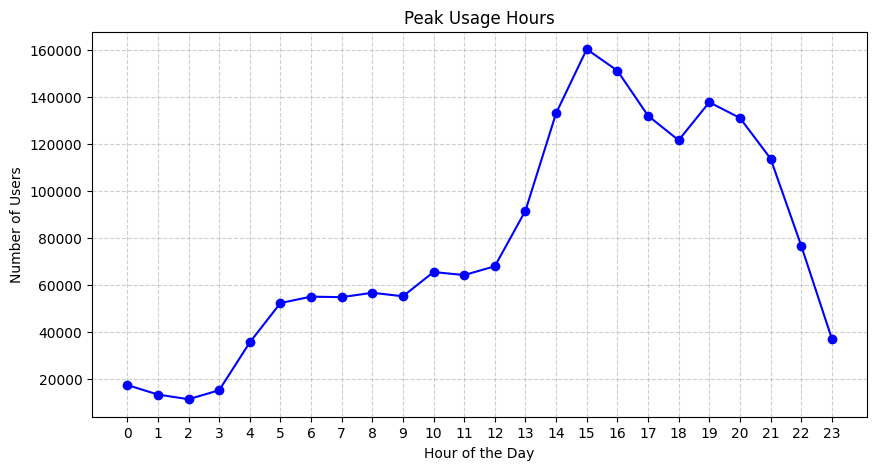

In [43]:
import pandas as pd
import os
import matplotlib.pyplot as plt

# Folder containing the CSV files
data_folder = "data"

# Dictionary to count user sessions per hour
hourly_usage = {hour: 0 for hour in range(24)}

# Loop through all CSV files
for file in os.listdir(data_folder):
    if file.endswith(".csv"):
        file_path = os.path.join(data_folder, file)
        df = pd.read_csv(file_path, usecols=['event_time'], low_memory=False)
        
        # Convert event_time to datetime format
        df['event_time'] = pd.to_datetime(df['event_time'], errors='coerce')
        
        # Extract hour and count occurrences
        hour_counts = df['event_time'].dt.hour.value_counts().to_dict()
        
        # Update global hourly usage
        for hour, count in hour_counts.items():
            hourly_usage[hour] += count

# Convert to DataFrame for plotting
hourly_df = pd.DataFrame(list(hourly_usage.items()), columns=['Hour', 'Users'])
hourly_df = hourly_df.sort_values(by='Hour')

# Plot as a line graph
plt.figure(figsize=(10, 5))
plt.plot(hourly_df['Hour'], hourly_df['Users'], marker='o', linestyle='-', color='blue')

# Formatting
plt.xticks(range(24))  # Ensure all hours are shown
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Users")
plt.title("Peak Usage Hours")
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()

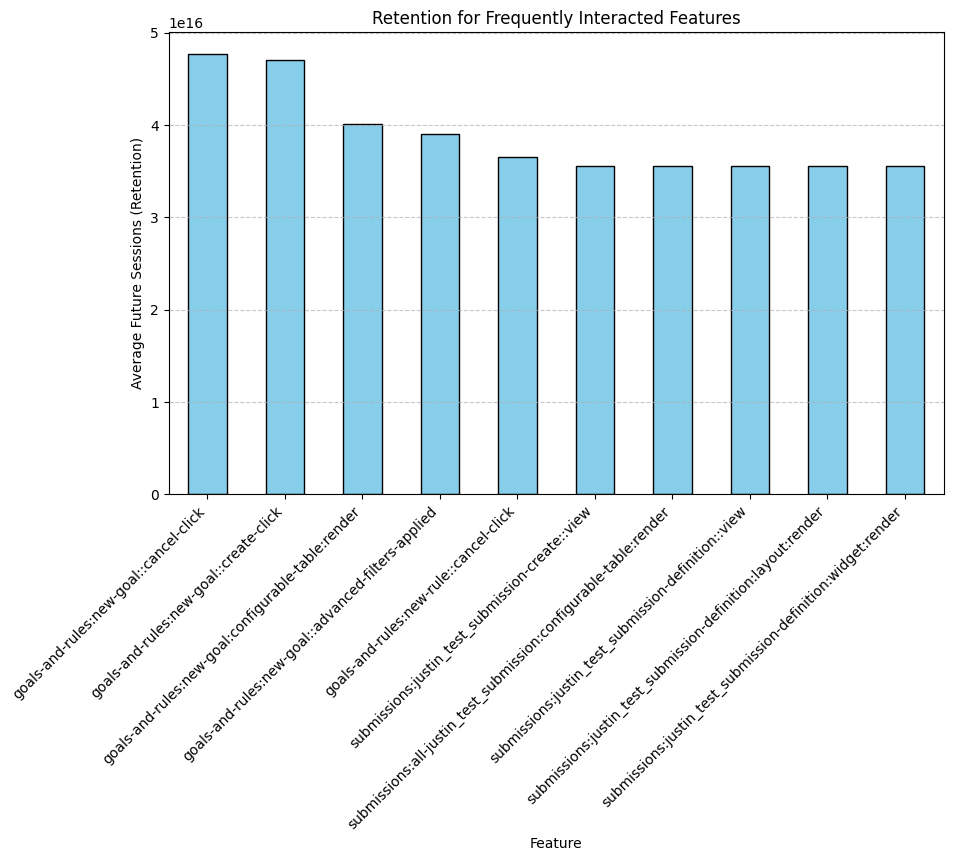

In [44]:
import pandas as pd
import os
import matplotlib.pyplot as plt

# Load all CSVs from the 'data' folder
folder_path = "data"
all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]

# Combine all CSVs into one DataFrame
df_list = [pd.read_csv(file, low_memory=False) for file in all_files]
df = pd.concat(df_list, ignore_index=True)

# Convert event_time to datetime
df['event_time'] = pd.to_datetime(df['event_time'])

# Count how many times each user interacted with each feature
feature_usage = df.groupby(['user_id', 'event_type']).size().reset_index(name='usage_count')

# Count total future sessions per user
df['future_sessions'] = df.groupby('user_id')['session_id'].transform(lambda x: x.iloc[::-1].cumsum())

# Get average future sessions for each feature
retention_per_feature = feature_usage.merge(df[['user_id', 'event_type', 'future_sessions']], on=['user_id', 'event_type'])
retention_per_feature = retention_per_feature.groupby('event_type')['future_sessions'].mean().sort_values(ascending=False)

# Select top 10 features with highest retention
top_features = retention_per_feature.head(10)

# Plot bar graph
plt.figure(figsize=(10, 6))
top_features.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel("Feature")
plt.ylabel("Average Future Sessions (Retention)")
plt.title("Retention for Frequently Interacted Features")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()